In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from enum import IntEnum
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import trange
from collections import defaultdict

from GrU_nn import (gru_module_1, gru_module_2, gru_module_3, gru_module_4, neuralGrU)
from GrU import (evaluate, GrU, getBestExporter, getCost)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

### Load auction data

In [3]:
class clock( IntEnum ):
    pv = 0
    storage = 1
    charge = 2
    discharge = 3

class source( IntEnum ):
    grid =  0
    pv = 1
    storage = 2
    charge = 3
    discharge = 4

df_auctioneer_data = pd.read_csv('../data/Auctioneer Data.csv')

headers = np.load(file='../data/clock_data_columns.npy', allow_pickle=True)
df_clock_data = pd.DataFrame(np.load('../data/clock_data_values.npy', allow_pickle=True), columns=headers)

def getPriceVectors(round):
    '''
    Get price vectors for a round from the clock data.

    Parameters
    ----------
    round : int
        Round number to get the price vectors for, range = [0, 308]

    Returns
    -------
    prices : ndarray of shape (5, 24)
        Price vectors for g, p, s, c, d.
    
    '''
    prices = np.ndarray((5, 24))
    prices[0] = df_auctioneer_data.GRID_PRICE.values
    for e in clock:
        prices[e + 1] = df_clock_data[f'price_{round}'][e]
    return prices

## Revenue Maximisation

In [4]:
def total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star):
    '''
    Loss = -revenue
    '''
    # r_g = pi_g * d_star[source.grid]
    r_p = pi_p * d_star[source.pv]
    r_s = pi_s * d_star[source.storage]
    r_c = pi_c * d_star[source.charge]
    r_d = pi_d * d_star[source.discharge]

    r_t = r_p + r_s + r_c + r_d
    rev = torch.sum(r_t)

    return -rev

In [5]:
# Init model
eta = 1
model = neuralGrU(B=1, eta_c=eta, eta_d=eta).to(device)

#### Input Data

In [6]:
prices = getPriceVectors(100)

# Random total demand tensor
d_t = torch.ones(24, requires_grad=False, device=device)
# d_t = torch.ones(24, requires_grad=False, device=device)

# Price tensors
pi_g = torch.tensor(prices[source.grid], requires_grad=False, device=device)

pi_p = torch.tensor(prices[source.pv], requires_grad=True, device=device)
pi_c = torch.tensor(prices[source.charge], requires_grad=True, device=device)
pi_d = torch.tensor(prices[source.discharge], requires_grad=True, device=device)
pi_s = torch.tensor(prices[source.storage], requires_grad=True, device=device)

#### Optimisation schedule

In [7]:
# Hyperparameter(s)
learning_rate = 1
epochs = 200

history = []

# Init optimizer & scheduler
optimizer = torch.optim.Adam([pi_p, pi_s, pi_c, pi_d], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.92)

for t in trange(epochs):
    # Compute prediction and loss
    d_star = model(pi_g, pi_p, pi_s, pi_c, pi_d, d_t)
    loss = total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()

    # Optimisation
    optimizer.step()
    scheduler.step()

    loss = loss.item()
    history.append(loss)

    # Curriculum Learning
    if t % 10 == 0 and model.B < 1e4:
        model.B *= 2

    # if t % 100 == 0:
    #     print(f"Epoch {t+1}     loss: {loss:>7f}")

100%|██████████| 200/200 [00:01<00:00, 117.70it/s]


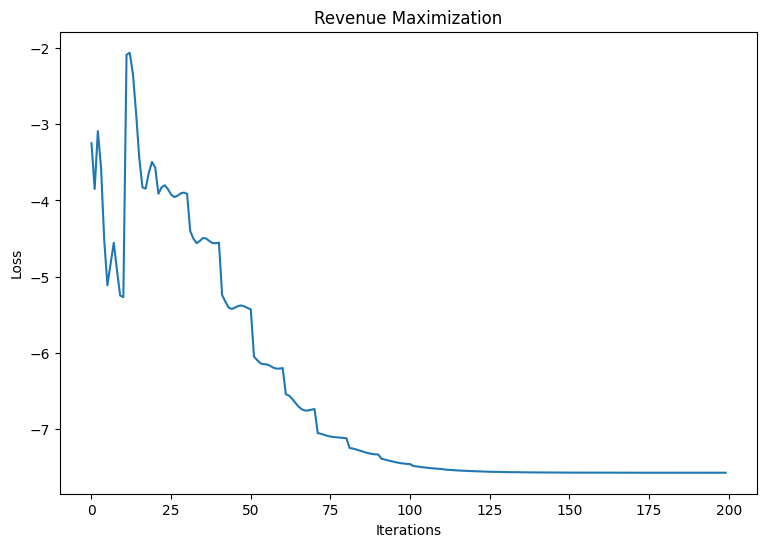

In [8]:
plt.figure(figsize=(9,6))
plt.plot(history, label='loss')
plt.title('Revenue Maximization')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [9]:
(pi_g > pi_p).all()

tensor(True)

In [10]:
pi_g - pi_p

tensor([0.0020, 0.0018, 0.0012, 0.0012, 0.0011, 0.0011, 0.0012, 0.0018, 0.0047,
        0.0050, 0.0029, 0.0015, 0.0015, 0.0016, 0.0015, 0.0016, 0.0015, 0.0034,
        0.0034, 0.0025, 0.0025, 0.0025, 0.0021, 0.0031], dtype=torch.float64,
       grad_fn=<SubBackward0>)

#### Demand breakup on optimised prices

In [11]:
pi = torch.stack([pi_g, pi_p, pi_s, pi_c, pi_d]).detach().numpy()

In [12]:
d_break_nn = model(pi_g, pi_p, pi_s, pi_c, pi_d, d_t).detach().numpy()
d_break, _ = GrU(d_t, pi, eta_c=eta, eta_d=eta)

In [13]:
evaluate(d_break, d_break_nn)[0]

[1.4514951832171197e-09, 1.4514952018096494e-09, 0.0, 0.0, 0.0]

In [14]:
d_break

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]])

## Revenue Maximisation with Gradient Clipping

1. No Curriculum Learning (for B). Init B at 10-20.
2. Gradients clipped at 0, i.e., updates to price(s) are non-negative.
3. Input price tensors are scaled to compensate for lower B.
4. ExponentialLR performs better than ReduceLROnPlateau.

In [15]:
def total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star):
    '''
    Loss = -revenue
    '''
    # r_g = pi_g * d_star[source.grid]
    r_p = pi_p * d_star[source.pv]
    r_s = pi_s * d_star[source.storage]
    r_c = pi_c * d_star[source.charge]
    r_d = pi_d * d_star[source.discharge]

    r_t = r_p + r_s + r_c + r_d
    rev = torch.sum(r_t)

    return -rev

In [16]:
# Init model
eta = 1
B = 10
scaler = 100

model = neuralGrU(B, device, eta, eta).to(device)

#### Input Data

In [17]:
prices = getPriceVectors(100) * scaler

# Random total demand tensor
d_t = torch.ones(24, requires_grad=False, device=device)
# d_t = torch.ones(24, requires_grad=False, device=device)

# Price tensors
pi_g = torch.tensor(prices[source.grid], requires_grad=False, device=device)

pi_p = torch.tensor(prices[source.pv], requires_grad=True, device=device)
pi_c = torch.tensor(prices[source.charge], requires_grad=True, device=device)
pi_d = torch.tensor(prices[source.discharge], requires_grad=True, device=device)
pi_s = torch.tensor(prices[source.storage], requires_grad=True, device=device)

#### Optimization schedule

In [18]:
# Hyperparameter(s)
learning_rate = 1e-1
epochs = 200

history_grad_clip = []

# Init optimizer & scheduler
optimizer = torch.optim.Adam([pi_p, pi_s, pi_c, pi_d], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.96)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)

for t in trange(epochs):
    # Compute prediction and loss
    d_star = model(pi_g, pi_p, pi_s, pi_c, pi_d, d_t)
    loss = total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    
    # Gradient Clipping
    for p in [pi_p, pi_s, pi_c, pi_d]:
        p.grad = -F.relu(-p.grad)

    optimizer.step()
    scheduler.step()
    # scheduler.step(loss)

    loss = loss.item()
    history_grad_clip.append(loss / scaler)

    # Curriculum Learning
    # if t % 10 == 0 and model.B < 1e4:
    #     model.B *= 2

    # if t % 100 == 0:
    #     print(f"Epoch {t+1}     loss: {loss:>7f}")

100%|██████████| 200/200 [00:01<00:00, 179.46it/s]


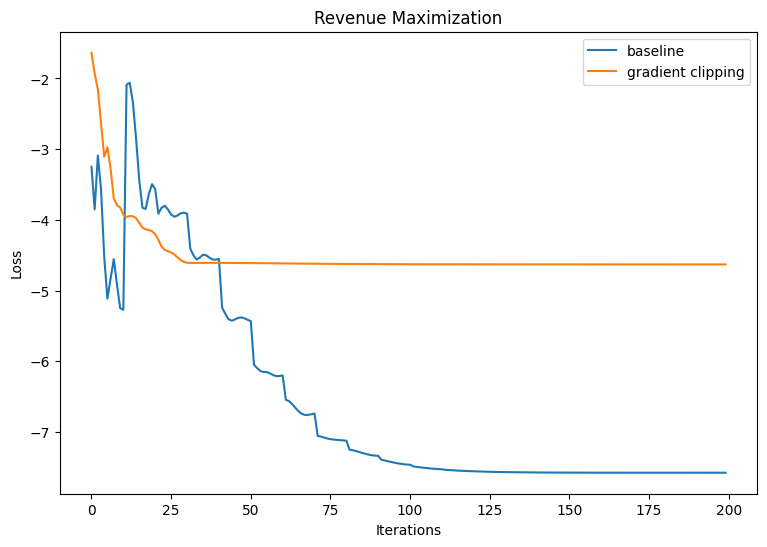

In [19]:
plt.figure(figsize=(9,6))
plt.plot(history, label='baseline')
plt.plot(history_grad_clip, label='gradient clipping')
plt.title('Revenue Maximization')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
(pi_g > pi_p).all()

tensor(False)

In [21]:
pi_g - pi_p

tensor([ -7.2211, -13.5218, -18.2524, -20.0054, -20.9482, -20.8110, -18.4848,
        -12.0159,   4.5073,   4.2787,   2.0667,   0.4774,   0.2174,   0.1609,
          0.4586,  -0.0550,  -0.0293,  -4.8319,   0.3987,   8.9474,  10.7212,
          9.0057,   6.3157,   0.2397], dtype=torch.float64,
       grad_fn=<SubBackward0>)

In [22]:
np.round(d_star.detach().numpy())

array([[1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
        0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]])

## Multi-agent Revenue Maximization

In [ ]:
def total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star):
    '''
    Loss = -revenue
    '''
    # r_g = pi_g * d_star[source.grid]
    r_p = pi_p * d_star[source.pv]
    r_s = pi_s * d_star[source.storage]
    r_c = pi_c * d_star[source.charge]
    r_d = pi_d * d_star[source.discharge]

    r_t = r_p + r_s + r_c + r_d
    rev = torch.sum(r_t)

    return -rev

In [ ]:
prices = getPriceVectors(300)

# Random total demand tensor
# d_t = torch.rand(24, requires_grad=False) * 10
d_t = torch.ones(24, requires_grad=False, device=device) * 10

# Price tensors
pi_g = torch.tensor(prices[source.grid], requires_grad=False, device=device)

pi_p = torch.tensor(prices[source.pv], requires_grad=True, device=device)
pi_c = torch.tensor(prices[source.charge], requires_grad=True, device=device)
pi_d = torch.tensor(prices[source.discharge], requires_grad=True, device=device)
pi_s = torch.tensor(prices[source.storage], requires_grad=True, device=device)

# EI tensor
ep = [0.00044688, 0.00044796, 0.00045042, 0.00045573, 0.00046029, 0.00046002, 0.00045153, 0.00043737, 0.00042772, 0.00041107, 0.00040774, 0.00038668, 0.00037268, 0.00036565, 0.00036387, 0.00035763, 0.00034319, 0.00034377, 0.00035285, 0.00037902, 0.00039631, 0.00040366, 0.00039713, 0.00039088]
ep_t = torch.tensor(ep, requires_grad=False, device=device) * 1e3

In [ ]:
n_agents = 5
gamma = [1, 2, 3, 4, 5]

models = {i: neuralGrU(B=1).to(device) for i in range(n_agents)}
d_star_n = torch.tensor(np.ndarray(shape=(n_agents, 5, 24)), device=device)

# Hyperparameter(s)
learning_rate = 1
epochs = 100

history = []

optimizer = torch.optim.Adam([pi_p, pi_s, pi_c, pi_d], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.92)

for t in trange(epochs):
    for agent in range(n_agents):
        # Update pi_g with EI
        pi_g_ei = pi_g + gamma[agent] * ep_t
        d_star_n[agent] = models[agent](pi_g_ei, pi_p, pi_s, pi_c, pi_d, d_t)

    d_star_total = torch.sum(d_star_n, dim=0)    
    loss = total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star_total)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    scheduler.step()

    loss = loss.item()
    history.append(loss)

    for agent in range(n_agents):
        if t % 10 == 0 and models[agent].B < 1e4:
            models[agent].B *= 2

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(history)
plt.title('Revenue Maximization')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [ ]:
pi_p

In [ ]:
ep_t * 3 + pi_g

In [ ]:
pi_g

In [ ]:
d_star_n[:, 1]

> PV demand of all 5 users